# **Amazon Fine Foods Review classification**

---







## **Problem Statement**

---


You are an Amazon data scientist and have been asked to find out insights from the 'Amazon Fine Foods Review' data. Your aim is to do text classification using Deep Learning on the reviews. This dataset has various features but for this project you will only need the reviews(text) as training data. This is a supervised Learning task so you will use Score as the label, while training. You have to make a classification model which will rate the review at a scale from 1 to 5.

## **About the dataset**

---


This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. The original data contains 568,454 reviews collected from 256,059 users on 74,258 products.

The snapshot of the data, you will be working on :

In [502]:
#Importing Libraries
import numpy as np
import pandas as pd
from keras.utils import np_utils 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import random as python_randomi
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding
import warnings
warnings.filterwarnings("ignore")
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import nltk
from keras.utils import np_utils 

In [503]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [504]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [505]:
#train data
path='/content/gdrive/My Drive/Amazon_fine_reviews/New_train.csv'
train=pd.read_csv(path)
train.head(5)

,Text,Score,Summary,count_adj,count_noun,count_adv,count_verb,pronoun
0,I bought these from a large chain pet store. a...,1,do not buy,2,8,2,8,5
1,"This soup is incredibly good! But honestly, I...",5,Really great taste! Price should be less though.,7,13,5,12,7
2,Our family loves these tasty and healthy sesam...,5,Tasty and Healthy Snack,13,45,1,19,9
3,The local auto shop offers this free to it cus...,4,"Quick, Easy and Tasty",2,6,4,8,8
4,I brought 2 bottles. One I carry in my pocket...,5,Love it!!,3,13,3,5,6


In [506]:
#test data
path='/content/gdrive/My Drive/Amazon_fine_reviews/New_test.csv'
test=pd.read_csv(path)
test.head(5)

,Text,Summary,count_adj,count_adv,count_verb,pronoun,noun
0,"This oatmeal is not good. Its mushy, soft, I d...",Don't like it,2,2,5,3,3
1,Buyer Beware Please! This sweetener is not for...,Warning! WARNING! -ALCOHOL SUGARS!,35,20,55,33,33
2,"Five minutes in, one tentacle was bitten off, ...",Sad outcome,1,4,6,0,0
3,"Kettle chips now look, feel and taste like Lay...",Surprise 1 It's different...,3,5,4,3,3
4,These chips are greasy and taste burnt-there i...,Chips,5,3,7,3,3


In [507]:
pip install emoji

In [508]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [509]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [510]:
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
#Lemmatization of data
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
import re
import re
import string
import os
import emoji
import textblob
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')+['link','quot','amp']
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 2] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = WordNetLemmatizer()
        words = input_text.split() 
        stemmed_words = [porter.lemmatize(word) for word in words]
        return " ".join(stemmed_words)

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X


ct = CleanText()
train['Text'] = ct.fit_transform(train.Text)
test['Text'] = ct.fit_transform(test.Text)
     

In [511]:
train.drop('Summary',1,inplace=True)
test.drop('Summary',1,inplace=True)

In [512]:
train=train[['Text','Score']]
test=test[['Text']]

In [513]:
max_len=max([len(s.split()) for s in train['Text']])
max_len

939

In [514]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [515]:
from nltk import word_tokenize
sent_len=[]
for sent in train['Text']:
  sent_len.append(len(word_tokenize(sent)))

In [516]:
np.quantile(sent_len,0.95)

115.0

In [517]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
x = train['Text']
y = train['Score']
token = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)
pad_seq = pad_sequences(seq,padding='post',maxlen=120)
vocab_size = len(token.word_index)+1

In [518]:
pad_seq

array([[   45,   242,  2526, ...,     0,     0,     0],
       [  311,  1768,     5, ...,     0,     0,     0],
       [  285,    15,   185, ...,     0,     0,     0],
       ...,
       [  238,   950,  1371, ...,     0,     0,     0],
       [   85,    35,    47, ...,     0,     0,     0],
       [ 2377,   176, 19054, ...,     0,     0,     0]], dtype=int32)

In [519]:
#Load embeddings into memory
embeddings_index=dict()
f='/content/gdrive/My Drive/Amazon_fine_reviews/glove.6B.100d.txt'

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [520]:
embedding_dim =100
embedding_matrix = create_embedding_matrix('/content/gdrive/My Drive/Amazon_fine_reviews/glove.6B.100d.txt',token.word_index, embedding_dim)

In [521]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7672411057158273

In [522]:
pad_seq=pd.DataFrame(pad_seq)
X=pad_seq
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,45,242,2526,343,54,586,67,1156,20,44,498,720,130,20,151,290,9,256,67,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,311,1768,5,830,126,26,326,28,80,186,14,1029,13,339,246,54,162,563,1029,351,58,26,326,16,5,195,311,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,285,15,185,163,1680,273,260,1621,1387,13,401,6,1680,328,2097,1071,611,273,260,599,937,14,114,165,5,112,119,1621,1387,260,114,260,5,1690,284,182,2826,114,713,14,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,192,2325,691,753,80,413,29,616,236,19,451,453,147,1,15,34,9,46,157,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1232,135,7,759,1244,291,1403,15,2753,9410,307,952,1413,72,1374,6,1,87,3130,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40495,227,4325,1060,926,170,46,30,45,227,926,18,949,252,10,19,926,18,238,895,235,704,535,181,519,87,41,98,21,7,51,227,990,10,376,120,54,831,235,3455,970,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40496,79,67,321,10540,6274,31506,472,4,301,4534,58,1083,312,2527,571,109,5395,23,3347,329,346,6,446,202,312,88,2,5774,543,2341,361,95,2006,941,5391,46,2538,575,312,10,...,1,1128,161,1095,151,137,2,79,11203,67,69,347,1294,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40497,238,950,1371,2462,12,12,1,2771,113,1739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40498,85,35,47,214,130,435,869,5,227,47,39,3528,5190,244,214,2025,3211,130,435,209,25,482,244,1,1972,80,1,827,214,60,262,7458,305,597,3553,398,1103,104,40,286,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [523]:
y=pd.DataFrame(train['Score'])
y = np_utils.to_categorical(y)
y=pd.DataFrame(y)
y.columns=['Score_0','Score_1','Score_2','Score_3','Score_4','Score_5']
y.drop('Score_0',1,inplace=True)
y

,Score_1,Score_2,Score_3,Score_4,Score_5
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
40495,0.0,0.0,0.0,0.0,1.0
40496,1.0,0.0,0.0,0.0,0.0
40497,0.0,0.0,0.0,0.0,1.0
40498,0.0,1.0,0.0,0.0,0.0


In [524]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=9)

In [525]:
X_train.shape,X_test.shape

((32400, 120), (8100, 120))

In [526]:
y_train.shape,y_test.shape

((32400, 5), (8100, 5))

In [470]:
#Scaling of Data
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# **GRU**

---



In [527]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,Flatten,Bidirectional,SimpleRNN,GRU
import tensorflow as tf
import random as python_random
import random as python_random
from keras.optimizers import Adam
from sklearn.utils import class_weight


# import packages
from keras import regularizers

np.random.seed(9)
python_random.seed(9)
tf.random.set_seed(9)
model = Sequential()
model.add(Embedding(vocab_size,100,weights=[embedding_matrix],input_length=120,trainable=False))
# Code starts here

model.add(GRU(512))
model.add(Dropout(0.2))
model.add(Dense(256,activation = 'relu',kernel_initializer='uniform'))
model.add(Dense(128,activation = 'relu',kernel_initializer='uniform'))
model.add(Dense(64,activation = 'relu',kernel_initializer='uniform'))
model.add(Dense(32,activation = 'relu',kernel_initializer='uniform'))
model.add(Dropout(0.2))

model.add(Dense(5,activation = 'softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

# import packages
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=0.001)

# early stopping
early_stop = EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)


model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=20,verbose=2,batch_size=200,callbacks=[early_stop,reduce_lr])
loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 120, 100)          3150900   
_________________________________________________________________
gru_21 (GRU)                 (None, 512)               943104    
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_106 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_107 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_108 (Dense)            (None, 32)              

In [535]:
token = Tokenizer()
token.fit_on_texts(test)
seq = token.texts_to_sequences(test)
pad_seq = pad_sequences(seq,padding='post',maxlen=120)
vocab_size = len(token.word_index)+1

In [536]:
pad_seq=pd.DataFrame(pad_seq)
pad_seq

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,302,1,8,1053,638,2,1531,1302,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,234,1168,35,31,92,39,3257,3258,53,353,57,71,31,92,39,3259,33,4,3260,487,1839,216,556,592,1166,3261,3262,1304,107,96,399,2301,2,3263,1840,3264,2299,955,1535,1536,...,8,957,3267,557,58,2302,441,1844,419,305,127,168,1166,517,58,958,868,1305,459,58,90,558,556,592,22,2303,3268,113,74,1166,957,271,240,2,25,959,116,2,1,1166
2,518,354,5,3269,3270,442,287,1306,152,1,2304,200,10,960,110,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,519,103,97,241,4,2,1307,103,53,259,3271,520,3272,355,259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,103,869,4,739,1308,305,18,103,1538,400,305,18,11,870,217,92,153,130,132,869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,37,55,258,10,125,949,1142,171,164,721,1353,19,5941,721,707,92,91,157,14,42,949,1142,2799,1528,287,52,616,1528,2236,3252,1286,949,1142,5942,2334,442,15,200,997,3252,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,838,1,392,803,42,148,1596,1097,285,1309,232,150,1157,217,92,14,1,3,109,84,397,481,466,5943,42,1,84,37,564,42,270,150,1,11,32,270,150,466,1051,777,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,5,33,213,27,566,180,92,111,144,995,900,2,247,213,22,36,839,213,5947,192,5,268,433,67,1995,5948,353,8,1029,213,58,177,43,231,1299,5949,4,2,5950,193,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,3,775,17,931,195,384,1061,52,1315,17,1472,42,52,1610,17,181,379,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [537]:
test_data=pad_seq
test_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,302,1,8,1053,638,2,1531,1302,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,234,1168,35,31,92,39,3257,3258,53,353,57,71,31,92,39,3259,33,4,3260,487,1839,216,556,592,1166,3261,3262,1304,107,96,399,2301,2,3263,1840,3264,2299,955,1535,1536,...,8,957,3267,557,58,2302,441,1844,419,305,127,168,1166,517,58,958,868,1305,459,58,90,558,556,592,22,2303,3268,113,74,1166,957,271,240,2,25,959,116,2,1,1166
2,518,354,5,3269,3270,442,287,1306,152,1,2304,200,10,960,110,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,519,103,97,241,4,2,1307,103,53,259,3271,520,3272,355,259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,103,869,4,739,1308,305,18,103,1538,400,305,18,11,870,217,92,153,130,132,869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,37,55,258,10,125,949,1142,171,164,721,1353,19,5941,721,707,92,91,157,14,42,949,1142,2799,1528,287,52,616,1528,2236,3252,1286,949,1142,5942,2334,442,15,200,997,3252,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,838,1,392,803,42,148,1596,1097,285,1309,232,150,1157,217,92,14,1,3,109,84,397,481,466,5943,42,1,84,37,564,42,270,150,1,11,32,270,150,466,1051,777,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,5,33,213,27,566,180,92,111,144,995,900,2,247,213,22,36,839,213,5947,192,5,268,433,67,1995,5948,353,8,1029,213,58,177,43,231,1299,5949,4,2,5950,193,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,3,775,17,931,195,384,1061,52,1315,17,1472,42,52,1610,17,181,379,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [538]:
y_pred=model.predict(test_data)

y_pred2=np.argmax(y_pred, axis=1)
y_pred2= [x+1 for x in y_pred2]



submission=pd.DataFrame(y_pred2)


# Create the submission file
submission.to_csv('GRU-3.csv',index=False,header=['Score'])

from google.colab import files
files.download('GRU-3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [337]:
submission

,0
0,2
1,2
2,2
3,1
4,4
...,...
995,1
996,1
997,2
998,2


## **Tfidf With Neural Network Approach**

---



In [150]:
train_1=train.sample(n=7000)
train_1

,Text,Score,Summary,count_adj,count_noun,count_adv,count_verb,pronoun
644,vegetarian others want eat quick easy cheap no...,4,Tasty!,8,25,3,9,3
31404,great product expiration date april short peri...,4,Good product; tight expiration date,4,14,2,6,2
19157,remember growing pork chop done shake bake bes...,4,Tasty quick pork chops,15,47,12,32,20
26476,purchased original website flavored sugar rasp...,1,Don't waste your money,5,7,1,4,2
29428,ernie pooch love treat trick command get zuke ...,5,Candy for Dogs!!!,0,15,1,7,4
...,...,...,...,...,...,...,...,...
34909,love cereal buy box costco sometimes offered b...,1,Too expensive,1,6,3,4,3
13494,good variety chocolate bad everyone say flavor...,4,I like this but...,6,14,2,8,5
6017,idea clever bud look attractive glass always o...,3,Attractive,3,4,4,6,2
23927,disposable cup great simple clean method porti...,5,Disposable K-Cups for Keurig Brewers,6,15,5,10,7


In [151]:
# Implement TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sb
import matplotlib.pyplot as plt
import gensim

tfidf_vect = TfidfVectorizer(ngram_range=(1,1))
tfidf_data = train_1['Text']
tfidf_data = tfidf_vect.fit_transform(tfidf_data)
tfidf_data = tfidf_data.todense()

In [152]:

# Implement Word2Vec
w2v_points =train_1['Text']
sent_list = []
for sent in w2v_points:
    sentence = sent.split()
    sent_list.append(sentence)
w2v_model = gensim.models.Word2Vec(sent_list, min_count=5, size=50, workers=4)
w2v_words = w2v_model[w2v_model.wv.vocab]

In [153]:
# Construct sentence vectors from aove 2 results
tfidf_feat = tfidf_vect.get_feature_names()
tfidf_w2v_vectors = []
row = 0
for sent in sent_list:
    sent_vec = np.zeros(200)
    weight_sum = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec*tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_vectors.append(sent_vec)
    row += 1

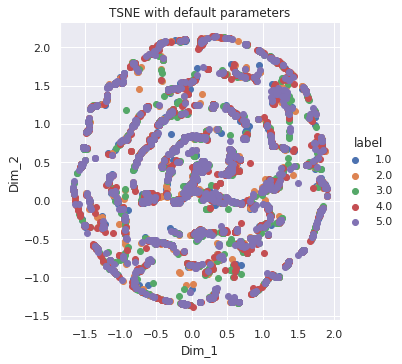

In [154]:
# Implement t-SNE
labels = train_1['Score']
model = TSNE(n_components=2, random_state=15, perplexity=30, n_iter=2000)
tfidf_w2v_points = model.fit_transform(tfidf_w2v_vectors)
tsne_data = np.vstack((tfidf_w2v_points.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))


# Plotting graph for class labels
sb.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with default parameters")
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()

In [158]:
# Tokenize words to be fed to the model
# Tokenize words to be fed to the model
max_fatures = 10000
tokenizer = Tokenizer()
X_test=tokenizer.fit_on_texts(test['Text'].values)
# tokenizer.fit_on_texts(X-test['Text'].values)
X_train = tokenizer.texts_to_sequences(train_1['Text'].values)
X_train = pad_sequences(X_train)
Y_train = pd.get_dummies(train_1['Score']).values

In [173]:
# Create the sequential model
embed_dim = 150
lstm_out = 200
max_fatures=10000
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))

# Create the sequential model
embed_dim = 150
lstm_out = 200
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


# Train
batch_size = 32
model.fit(X_train, Y_train, epochs = 8,batch_size=batch_size, verbose = 2)


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 409, 150)          1500000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 1005      
Total params: 1,781,805
Trainable params: 1,781,805
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
219/219 - 10s - loss: 1.4304 - accuracy: 0.3559
Epoch 2/8
219/219 - 10s - loss: 1.1302 - accuracy: 0.5173
Epoch 3/8
219/219 - 10s - loss: 0.9063 - accuracy: 0.6383
Epoch 4/8
219/219 - 10s - loss: 0.6939 - accuracy: 0.7354
Epoch 5/8
219/219 - 10s - loss: 0.5255 - accuracy: 0.8047
Epoch 6/8
219/219 - 10s - loss: 0.3959 - accuracy: 0.8574
Epoch 7/8
219/219 - 

In [171]:
test

,Text,Summary,count_adj,count_adv,count_verb,pronoun,noun
0,oatmeal not good mushy soft like quaker oat way,Don't like it,2,2,5,3,3
1,buyer beware please sweetener not everybody ma...,Warning! WARNING! -ALCOHOL SUGARS!,35,20,55,33,33
2,five minute one tentacle bitten ball inside cr...,Sad outcome,1,4,6,0,0
3,kettle chip look feel taste like lay chip used...,Surprise 1 It's different...,3,5,4,3,3
4,chip greasy taste burnt grease bottom bag chip...,Chips,5,3,7,3,3
...,...,...,...,...,...,...,...
995,order pack large dog chicken pill pocket every...,A quality control issue maybe?,11,10,24,16,16
996,fault not pay attention ordered went jack link...,dark meat,14,19,41,26,26
997,one first cracker tried yes gluten free may wo...,So So,12,9,20,11,11
998,product packing box leaking least single serve...,french vanilla,1,1,3,2,2


In [174]:
X_test1 = tokenizer.texts_to_sequences(test['Text'])
X_test1 = pad_sequences(X_test1, maxlen=X_train.shape[1])

y_pred=model.predict(X_test1)

y_pred2=np.argmax(y_pred, axis=1)
y_pred2= [x+1 for x in y_pred2]
y


submission=pd.DataFrame(y_pred2)


# Create the submission file
submission.to_csv('submission_reviews.csv',index=False,header=['Score'])

In [176]:
submission.columns=['Score']

In [177]:
from google.colab import files
files.download('submission_reviews.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>